In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
# !wget https://www.mimuw.edu.pl/~ciebie/gsn-2021-1.zip
# !unzip gsn-2021-1.zip &> /dev/null
# !rm gsn-2021-1.zip

In [9]:
class FiguresDataset(Dataset):
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, train, transform=None):
        self.figures_frame = pd.read_csv(csv_file)
        if train:
            self.figures_frame = self.figures_frame[:9000]
        else:
            self.figures_frame = self.figures_frame[-1000:]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.figures_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.figures_frame.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True);
        figures = self.figures_frame.iloc[idx, 1:]
        figures = np.array(figures)
        figures = figures.astype('int')
        sample = (image, figures)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
class ToTensor(object):
    def __call__(self, sample):
        image, figures = sample
        
        return (torch.from_numpy(image).float(), torch.from_numpy(figures))
    
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, figures = sample
        
        norm = transforms.Normalize(self.mean, self.std)
        image = norm(image.unsqueeze_(2)).squeeze_(2)
        
        return (image, figures)

class HorizontalFlip(object):
    def __call__(self, sample):
        image, figures = sample
        
        image = transforms.functional.hflip(image)
        figures[3], figures[5] = figures[5].clone(), figures[3].clone()
        
        return (image, figures)

class VerticalFlip(object):
    def __call__(self, sample):
        image, figures = sample
        
        image = transforms.functional.vflip(image)
        figures[2], figures[4] = figures[4].clone(), figures[2].clone() 
        
        return (image, figures)
    
class Rotate(object):
    def __init__(self):
        self.ks = [0, 1, 2, 3]
        
    def __call__(self, sample):
        image, figures = sample
        
        k = int(np.random.choice(self.ks))        
        image = torch.rot90(image, k)
        figures[2:] = torch.roll(figures[2:], -k)
        
        return (image, figures)

class ToClass(object):
    def __init__(self):
        self.dct = {}
        for i in range(6):
            for j in range(i+1, 6):
                for c in range(1,10):
                    a = np.zeros(6, dtype='int')
                    a[i] = c
                    a[j] = 10 - c
                    self.dct[str(a)] = len(self.dct)
        
    def __call__(self, sample):
        image, figures = sample

        cls = self.dct[str(figures.numpy())]
        
        return (image, cls)

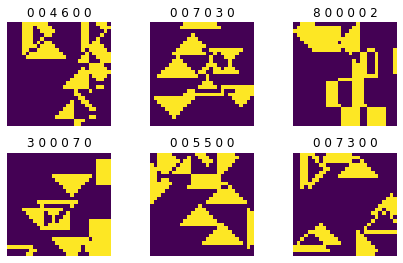

In [11]:
from random import randint

csv_file = csv_file='data/labels.csv'
root_dir = 'data/'
figures_dataset = FiguresDataset(csv_file, root_dir, train=True)

fig = plt.figure()

for i in range(6):
    r = randint(0, len(figures_dataset))
    image, figures = figures_dataset[r]

    
    ax = plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    ax.set_title(' '.join(map(str, figures)))
    ax.axis('off')
    
    plt.imshow(image)

plt.subplots_adjust()
plt.show()

In [12]:
torch.manual_seed(1)
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

torch.manual_seed(1)

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if device == 'cuda':
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    


transform = transforms.Compose([ToTensor(), Normalize(mean=0.5, std=0.5)])

train_dataset = FiguresDataset(csv_file, root_dir, True, transforms.Compose([transform, transforms.RandomApply([transforms.RandomChoice([Rotate(), VerticalFlip(), HorizontalFlip()])], p=0.7), ToClass()]))
test_dataset = FiguresDataset(csv_file, root_dir, False, transforms.Compose([transform, ToClass()]))


train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [13]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=.00001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.stop = False
        
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.min_delta:
            self.best_loss = loss
        elif self.best_loss - loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
    

In [14]:
def eval_metric(output, target):
    pred = output.argmax(dim=1)
    return torch.sum(torch.eq(pred, target))
    

def train(model, device, train_loader, optimizer, log=False):
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        correct += eval_metric(output, target).item()
        loss.backward()
        optimizer.step()
        
        if log and batch_idx % 10 == 0:
            print('Train Batch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss
            correct += eval_metric(output, target).item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

def train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping=None):
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []
    
    for epoch in range(1, epochs + 1):
        print("\nEpoch: {}/{}\n".format(epoch, epochs))
        train_loss_epoch, train_accuracy_epoch = train(model, device, train_loader, optimizer)
        test_loss_epoch, test_accuracy_epoch = test(model, device, test_loader)
        
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_accuracy_epoch)
        test_loss.append(test_loss_epoch)
        test_accuracy.append(test_accuracy_epoch)
        
        print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(train_loss_epoch, train_accuracy_epoch))
        print('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_epoch, test_accuracy_epoch))
        
        if not early_stopping == None:
            early_stopping(train_loss_epoch)
            if early_stopping.stop:
                print("Early stopped.")
                break
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    l1, = ax1.plot(train_loss, color='b', label="Train")
    l2, = ax1.plot(test_loss, color='r', label='Test')
    ax1.set_title('Losses')
    ax2.plot(train_accuracy, color='b', label="Train")
    ax2.plot(test_accuracy, color='r', label='Test')
    ax2.set_title('Accuracies')
    plt.legend([l1, l2], ["Train", "Test"])

    plt.show()
        


Epoch: 1/100

Train set: Average loss: 0.0654, Accuracy: 8%
Test set: Average loss: 0.0032, Accuracy: 18%

Epoch: 2/100

Train set: Average loss: 0.0385, Accuracy: 28%
Test set: Average loss: 0.0027, Accuracy: 23%

Epoch: 3/100

Train set: Average loss: 0.0315, Accuracy: 35%
Test set: Average loss: 0.0019, Accuracy: 36%

Epoch: 4/100

Train set: Average loss: 0.0288, Accuracy: 38%
Test set: Average loss: 0.0015, Accuracy: 48%

Epoch: 5/100

Train set: Average loss: 0.0272, Accuracy: 40%
Test set: Average loss: 0.0015, Accuracy: 46%

Epoch: 6/100

Train set: Average loss: 0.0261, Accuracy: 41%
Test set: Average loss: 0.0017, Accuracy: 38%

Epoch: 7/100

Train set: Average loss: 0.0254, Accuracy: 42%
Test set: Average loss: 0.0015, Accuracy: 43%

Epoch: 8/100

Train set: Average loss: 0.0247, Accuracy: 43%
Test set: Average loss: 0.0014, Accuracy: 46%

Epoch: 9/100

Train set: Average loss: 0.0237, Accuracy: 45%
Test set: Average loss: 0.0013, Accuracy: 50%

Epoch: 10/100

Train set: Av

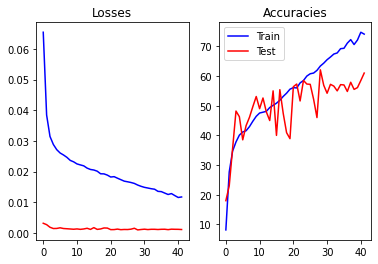

In [9]:
class Conv8Lin3BNFullPool3Pad(nn.Module):
    def __init__(self):
        super(Conv8Lin3BNFullPool3Pad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(1024 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 135),
            nn.BatchNorm1d(135),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv8Lin3BNFullPool3Pad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 0.0631, Accuracy: 7%
Test set: Average loss: 0.0034, Accuracy: 8%

Epoch: 2/100

Train set: Average loss: 0.0358, Accuracy: 26%
Test set: Average loss: 0.0019, Accuracy: 32%

Epoch: 3/100

Train set: Average loss: 0.0265, Accuracy: 36%
Test set: Average loss: 0.0019, Accuracy: 28%

Epoch: 4/100

Train set: Average loss: 0.0238, Accuracy: 39%
Test set: Average loss: 0.0030, Accuracy: 16%

Epoch: 5/100

Train set: Average loss: 0.0220, Accuracy: 43%
Test set: Average loss: 0.0017, Accuracy: 33%

Epoch: 6/100

Train set: Average loss: 0.0207, Accuracy: 46%
Test set: Average loss: 0.0015, Accuracy: 39%

Epoch: 7/100

Train set: Average loss: 0.0199, Accuracy: 47%
Test set: Average loss: 0.0013, Accuracy: 42%

Epoch: 8/100

Train set: Average loss: 0.0191, Accuracy: 49%
Test set: Average loss: 0.0014, Accuracy: 43%

Epoch: 9/100

Train set: Average loss: 0.0185, Accuracy: 50%
Test set: Average loss: 0.0012, Accuracy: 48%

Epoch: 10/100

Train set: Ave

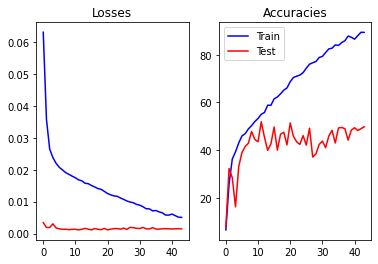

In [15]:
class Conv8Lin3BN3Pad(nn.Module):
    def __init__(self):
        super(Conv8Lin3BN3Pad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(1024 * 28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 135),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv8Lin3BN3Pad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/100

Train set: Average loss: 0.0739, Accuracy: 1%
Test set: Average loss: 0.0047, Accuracy: 1%

Epoch: 2/100

Train set: Average loss: 0.0659, Accuracy: 3%
Test set: Average loss: 0.0038, Accuracy: 4%

Epoch: 3/100

Train set: Average loss: 0.0538, Accuracy: 8%
Test set: Average loss: 0.0030, Accuracy: 12%

Epoch: 4/100

Train set: Average loss: 0.0413, Accuracy: 18%
Test set: Average loss: 0.0024, Accuracy: 20%

Epoch: 5/100

Train set: Average loss: 0.0326, Accuracy: 27%
Test set: Average loss: 0.0020, Accuracy: 29%

Epoch: 6/100

Train set: Average loss: 0.0278, Accuracy: 33%
Test set: Average loss: 0.0017, Accuracy: 33%

Epoch: 7/100

Train set: Average loss: 0.0247, Accuracy: 39%
Test set: Average loss: 0.0017, Accuracy: 34%

Epoch: 8/100

Train set: Average loss: 0.0237, Accuracy: 40%
Test set: Average loss: 0.0016, Accuracy: 36%

Epoch: 9/100

Train set: Average loss: 0.0220, Accuracy: 44%
Test set: Average loss: 0.0016, Accuracy: 40%

Epoch: 10/100

Train set: Averag

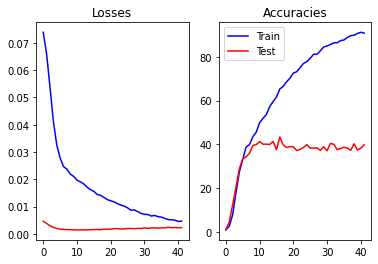

In [16]:
class Conv5Lin2Pad(nn.Module):
    def __init__(self):
        super(Conv5Lin2Pad, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 135),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output
    
model = Conv5Lin2Pad().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 100

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)